<a href="https://colab.research.google.com/github/YungHapon/Hacklytics-2023---Team-BTr-PH/blob/main/debt_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR,SVR
from sklearn.decomposition import PCA
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D


In [48]:
#User inputs

#Step 1:
print("Step 1 Inputs")

stress = { #base scenario as of end 2022 of factors affecting yield curve
    "INF": 8.1, 
    "ON_RRP": 5.5,
    "US_1M": 3.997,
    "US_7Y": 3.683,
    "5Y_CDS": 97.11,
    "CR": 11,
    "VT": 341169.08,
    "VIX": 21.67,
    "OP": 80.26,
    "GF": 1826.2
}

for key,value in stress.items():
  if key in ["INF","5Y_CDS","OP","GF","VIX"]:
    stress[key] = (int(input(key+" (% increase): "))+100)/100*value
  elif key in ["ON_RRP","US_1M","US_7Y"]:
    stress[key] = int(input(key+" (bps increase): "))/100+value
  elif key == "VT":
    stress[key] = (100-int(input(key+" (% reduction): ")))/100*value
  else:
    stress[key] = int(input(key+" (AAA=1, D=22): "))

#Step 3:
print("Step 3 Inputs")
initial_debt = float(input("Initial Debt Levels in percentage: "))/100
gdp_growth = float(input("Steady state GDP growth of country in percentage: "))/100
max_exp_adj = float(input("Maximum allowable adjustment in expenditures (in %): "))/100

#Step 5:
print("Step 5 Inputs")

gdp_new = float(input("Projected GDP for next year (in blns): ")) #20829.353 #projected GDP for the following year

t_old = float(input("Current debt (in blns): ")) #13419 #emerging total debt as of end 2022
wair_old = float(input("Current WAIR (in %): "))/100 #0.0439 #current weighted average interest rate of the debt issuances of the sovereign

cb_old =  float(input("Cash balance as of last EOY (in blns): ")) #213.86 #original cash balance as of end 2022
dp_old = float(input("Total debt issuances that will mature next year (in blns): "))  #410 #maturing issuances that need to be paid next year
ip_old = float(input("Interest payments of current issuances(in blns): ")) #571.10 #interest payments for current issuances next year


Step 1 Inputs
INF (% increase): 56
ON_RRP (bps increase): 100
US_1M (bps increase): 100
US_7Y (bps increase): 100
5Y_CDS (% increase): 50
CR (AAA=1, D=22): 11
VT (% reduction): 75
VIX (% increase): 50
OP (% increase): 50
GF (% increase): 50
Step 3 Inputs
Initial Debt Levels in percentage: 56.4
Steady state GDP growth of country in percentage: 4.31
Maximum allowable adjustment in expenditures (in %): 22.5
Step 5 Inputs
Projected GDP for next year (in blns): 20829.353
Current debt (in blns): 13419
Current WAIR (in %): 4.39
Cash balance as of last EOY (in blns): 213.86
Total debt issuances that will mature next year (in blns): 410
Interest payments of current issuances(in blns): 571.1


# Step 1: Yield Curve

In [7]:
#import necessary historical data on factors affecting yield curve
csv_files = [
    "https://raw.githubusercontent.com/YungHapon/Hacklytics-2023---Team-BTr-PH/main/Files/Yield/PH%201M%20Selected%20Features%20Data.csv",
    "https://raw.githubusercontent.com/YungHapon/Hacklytics-2023---Team-BTr-PH/main/Files/Yield/PH%203M%20Selected%20Features%20Data.csv",
    "https://raw.githubusercontent.com/YungHapon/Hacklytics-2023---Team-BTr-PH/main/Files/Yield/PH%206M%20Selected%20Features%20Data.csv",
    "https://raw.githubusercontent.com/YungHapon/Hacklytics-2023---Team-BTr-PH/main/Files/Yield/PH%201Y%20Selected%20Features%20Data.csv",
    "https://raw.githubusercontent.com/YungHapon/Hacklytics-2023---Team-BTr-PH/main/Files/Yield/PH%202Y%20Selected%20Features%20Data.csv",
    "https://raw.githubusercontent.com/YungHapon/Hacklytics-2023---Team-BTr-PH/main/Files/Yield/PH%203Y%20Selected%20Features%20Data.csv",
    "https://raw.githubusercontent.com/YungHapon/Hacklytics-2023---Team-BTr-PH/main/Files/Yield/PH%204Y%20Selected%20Features%20Data.csv",
    "https://raw.githubusercontent.com/YungHapon/Hacklytics-2023---Team-BTr-PH/main/Files/Yield/PH%205Y%20Selected%20Features%20Data.csv",
    "https://raw.githubusercontent.com/YungHapon/Hacklytics-2023---Team-BTr-PH/main/Files/Yield/PH%207Y%20Selected%20Features%20Data.csv",
    "https://raw.githubusercontent.com/YungHapon/Hacklytics-2023---Team-BTr-PH/main/Files/Yield/PH%2010Y%20Selected%20Features%20Data.csv",
    "https://raw.githubusercontent.com/YungHapon/Hacklytics-2023---Team-BTr-PH/main/Files/Yield/PH%2020Y%20Selected%20Features%20Data.csv",
]

In [8]:
def shock_yield_linearSVR(data): #ML model using linear support vector regression

  data.columns = data.columns.str.replace(r'\W+', '_', regex=True) #match stress scenario list format
  data = data.dropna(axis=1) 
  x = data.iloc[:,1:]
  y = data.iloc[:,0] #yield rates as dependent  variable

  scale = preprocessing.StandardScaler()
  x_train = scale.fit_transform(x)

  svm_regr = LinearSVR().fit(x,y)

  df = pd.DataFrame()
  for col in x.columns:
    df.loc[0,col] = stress[col]
  pred = svm_regr.predict(df)[0]
  pred = round(pred,4)

  return svm_regr.score(x,y),pred


In [9]:
def linearSVR(): #iterate through the different files for different tenors
  yield_curve = list()
  for filename in csv_files:
    data = pd.read_csv(filename,
                    index_col=0,
                    parse_dates=True
                    )
    yield_curve.append(shock_yield_linearSVR(data))

  return pd.DataFrame(yield_curve,columns=["linear SVR","linear SVR yield"])

## SVM Kernels

In [10]:
def shock_yield(data,kernel): #support vector machine model with kernel as argument

  data.columns = data.columns.str.replace(r'\W+', '_', regex=True)
  data = data.dropna(axis=1)
  x = data.iloc[:,1:]
  y = data.iloc[:,0]

  scale = preprocessing.StandardScaler()
  x_train = scale.fit_transform(x)

  svm_regr = SVR(kernel=kernel).fit(x,y)

  df = pd.DataFrame()
  for col in x.columns:
    df.loc[0,col] = stress[col]
  pred = svm_regr.predict(df)[0]
  pred = round(pred,4)

  return svm_regr.score(x,y),pred


In [11]:
def svr_kernel(kernel): #iterate through the different files for different tenors 

  yield_curve = list()
  for filename in csv_files:
    data = pd.read_csv(filename,
                    index_col=0,
                    parse_dates=True
                    )
    yield_curve.append(shock_yield(data,kernel))

  return pd.DataFrame(yield_curve,columns=[kernel+" SVR",kernel+" SVR yield"])

## OLS Regression

In [12]:
def shock_yield_ols(data): #ordinary least squares regression model

  data.columns = data.columns.str.replace(r'\W+', '_', regex=True)
  data = data.dropna(axis=1)
  x = data.iloc[:,1:]
  y = data.iloc[:,0]

  scale = preprocessing.StandardScaler()
  x_train = scale.fit_transform(x)
  
  ols_regr = LinearRegression().fit(x,y)

  df = pd.DataFrame()
  for col in x.columns:
    df.loc[0,col] = stress[col]
  pred = ols_regr.predict(df)[0]
  pred = round(pred,4)

  return ols_regr.score(x,y), pred


In [13]:
def ols(): #iterate through the different files for different tenors
  yield_curve = list()
  for filename in csv_files:
    data = pd.read_csv(filename,
                    index_col=0,
                    parse_dates=True
                    )
    yield_curve.append(shock_yield_ols(data))

  return pd.DataFrame(yield_curve,columns=["OLS","OLS yield"])

## Principal Component Analysis

In [14]:
def shock_yield_pca(data):

  data.columns = data.columns.str.replace(r'\W+', '_', regex=True)
  data = data.dropna(axis=1)

  x = data.iloc[:,1:]
  y = data.iloc[:,0]

  pca = PCA(n_components = len(x.columns))
  x_pca = pca.fit_transform(x)

  PCA_regr = LinearRegression().fit(x_pca,y)

  df = pd.DataFrame()
  for col in x.columns:
    df.loc[0,col] = stress[col]
  pred_pca = PCA(n_components=1).fit_transform(df)

  pred = PCA_regr.predict(df)[0]
  pred = round(pred,4)

  return PCA_regr.score(x,y), pred

In [15]:
def pca():
  yield_curve = list()
  for filename in csv_files:
    data = pd.read_csv(filename,
                    index_col=0,
                    parse_dates=True
                    )
    yield_curve.append(shock_yield_pca(data))

  return pd.DataFrame(yield_curve,columns=["PCA","PCA yield"])

In [16]:
#dataframe of scores and yields in order to use best performing model for each individual tenor, getting the yield from df_yield 
df_score = df_yield = pd.DataFrame(["1M","3M","6M","1Y","2Y","3Y","4Y","5Y","7Y","10Y","20Y"], columns=["Tenor"])

df_score = df_score.join(linearSVR()["linear SVR"]) 
df_yield = df_yield.join(linearSVR()["linear SVR yield"]) #run linear SVR

kernel_lst = ["rbf","poly","sigmoid"]
for kernel in kernel_lst: #run SVR kernels
  df = svr_kernel(kernel)
  df_score=df_score.join(df[kernel+" SVR"])
  df_yield=df_yield.join(df[kernel+" SVR yield"])

df_score = df_score.join(ols()["OLS"])
df_score = df_score.join(pca()["PCA"])

df_yield = df_yield.join(ols()["OLS yield"])
df_yield = df_yield.join(pca()["PCA yield"])

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warning

In [17]:
df_score = df_score.set_index("Tenor")
df_yield = df_yield.set_index("Tenor")

In [18]:
df_score['Optimal Model'] = df_score.idxmax(axis=1) #identify best performing model

In [19]:
shock_yields = list()
for i in range(11): #for each best performing model, get corresponding yield from df_yield
  shock_yields.append(df_yield[df_score["Optimal Model"].iloc[i]+" yield"].iloc[i])

#original yield rates as of end 2022
original_yields = [3.919, 4.2269, 4.9002, 5.2099, 5.9706, 6.2464, 6.3755, 6.47, 6.6585, 6.986, 7.2234]

#add original and shock scenario to df to plot
df_score["Shock Scenario Yields"] = shock_yields
df_score["Original Yields"] = original_yields
df_score["Difference"] = df_score["Shock Scenario Yields"] - df_score["Original Yields"]

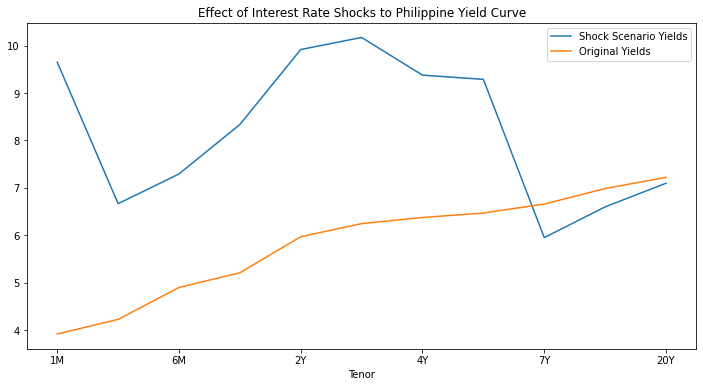

In [20]:

lines = df_score.iloc[:,-3:-1].plot.line(figsize=(12,6), title="Effect of Interest Rate Shocks to Philippine Yield Curve")

# Step 2: Simulation

In [21]:
#load data for revenues and expenditures
df = pd.read_csv("https://raw.githubusercontent.com/YungHapon/Hacklytics-2023---Team-BTr-PH/main/Files/Real%20Revenues%20and%20Expenditures.csv", index_col = 0)

In [22]:
#inputs: column name of needed pct change and transformation, output, df and sorted list of column percentage
def get_transform(df,col):
  col_pctchange = col+"_change"
  df[col_pctchange] = df[col].pct_change()
  transform_reference = df[col_pctchange].sort_values()
  transform_reference.dropna(inplace=True)
  return df, transform_reference, len(transform_reference)

In [23]:
#setup simulation random numbers. 1000 sims, 20 movements
np.random.seed(20)
sim = np.random.random(size = (21,1000))

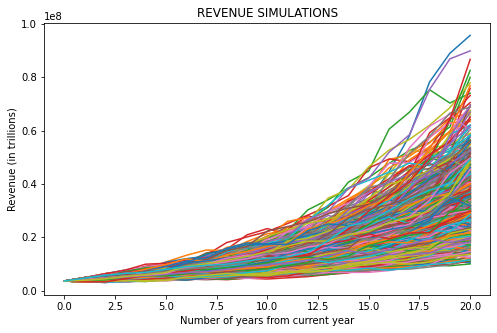

In [24]:
#simulate revenue and plot
df,transform,data_len = get_transform(df,"revenue")

#adjust to the length of the transform reference to get the index of transform equivalent
sim = np.floor(sim*data_len)

#get the equivalent from transform
rows = sim.shape[0]
cols = sim.shape[1]
for i in range (0,rows):
  for j in range (0, cols):
    sim[i,j] = transform.iloc[int(sim[i,j])]

s = df["revenue"].iloc[-1]
pred = np.zeros_like(sim) + 1
pred[0] = s         #sets beginning point of simulations
for i in range(1,21) :
  pred[i] = pred[(i-1)] * (1 + sim[(i-1)])

plt.figure(figsize = (8,5))
plt.title('REVENUE SIMULATIONS')    
for i in range(0,1000):
  plt.plot(pred[:, i])
plt.xlabel("Number of years from current year")
plt.ylabel("Revenue (in trillions)")
plt.show()

In [25]:
_#get the minimum revenue from each yearsim
min_rev_lst = list()
for path in pred:
  min_rev = np.mean(path) 
  min_rev_lst.append(min_rev)

In [26]:
#setup simulation random numbers. 1000 sims, 20 movements
np.random.seed(20)
sim = np.random.random(size = (21,1000))

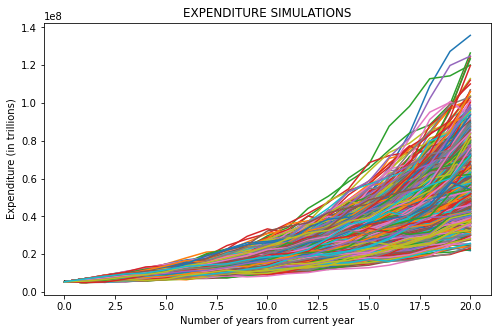

In [27]:
#simulate expenditures and plot
df,transform,data_len = get_transform(df,"expenditure")

#adjust to the length of the transform reference to get the index of transform equivalent
sim = np.floor(sim*data_len)

#get the equivalent from transform
rows = sim.shape[0]
cols = sim.shape[1]
for i in range (0,rows):
  for j in range (0, cols):
    sim[i,j] = transform.iloc[int(sim[i,j])]

s = df["expenditure"].iloc[-1]
pred_exp = np.zeros_like(sim) + 1
pred_exp[0] = s         #sets beginning point of simulations
for i in range(1,21) :
  pred_exp[i] = pred_exp[(i-1)] * (1 + sim[(i-1)])

plt.figure(figsize = (8,5))
plt.title('EXPENDITURE SIMULATIONS')    
for i in range(0,1000):
  plt.plot(pred_exp[:, i])
plt.xlabel("Number of years from current year")
plt.ylabel("Expenditure (in trillions)")
plt.show()
#add units in graph (Mlns, Blns etc.)
# simulate deficit path based on revenue path 1, expenditure path 2 and so on

In [28]:
#get the maximum expenditure from each year
max_exp_lst = list()
for path in pred_exp:
  max_exp = np.mean(path) 
  max_exp_lst.append(max_exp)

In [29]:
#simulated deficit based on individual paths
pred_deficit = pred_exp-pred

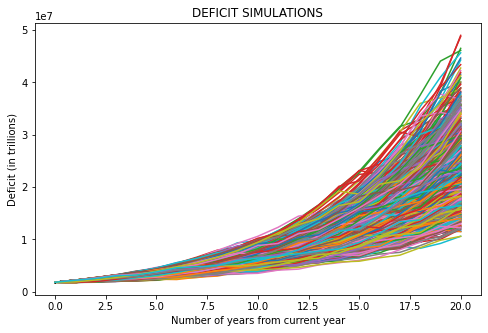

In [30]:
plt.figure(figsize = (8,5))
plt.title('DEFICIT SIMULATIONS')    
for i in range(0,1000):
  plt.plot(pred_deficit[:, i])
plt.xlabel("Number of years from current year")
plt.ylabel("Deficit (in trillions)")
plt.show()

In [31]:
year = range(2022,2043)
df_sim = pd.DataFrame( #create dataframe to plot delevant datapoints
    {"Year": year,
     "Minimum Revenue": min_rev_lst,
     "Maximum Expenditure": max_exp_lst
     })
df_sim = df_sim.set_index("Year")
df_sim["Deficit"] = df_sim["Maximum Expenditure"] - df_sim["Minimum Revenue"]


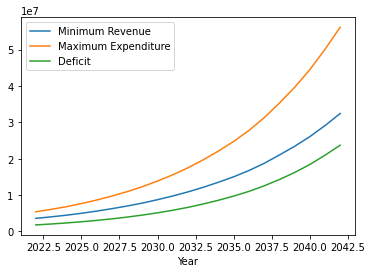

In [32]:
lines = df_sim.plot.line()

# Step 3: MO Model

In [33]:
#load data on revenues and non interest expense as percentage of GDP
df = pd.read_csv("https://raw.githubusercontent.com/YungHapon/Hacklytics-2023---Team-BTr-PH/main/Files/MO%20Model%20Input.csv")
df = df.dropna()

In [34]:
# MO model estimates the debt threshold of a sovereign based on average revenue, average expenditure, volatility of revenue,
# maximum allowable decrease in expenditure, growth rate, and the real world interest rate.
# sensitivity analysis can be made by adjusting expenditure decrease and assuming different revenue volatility
# source: https://www.econstor.eu/bitstream/10419/88089/1/idb-wp_511.pdf

rev_ave = np.mean(df["Revenue"])
exp_ave = np.mean(df["Expenditure"])
rev_sd = np.std(df["Revenue"])
rate = 0.065 #taken as given, assumption on world real interest rate


#set the values for table in revenue volatility
vol1 = (round(rev_sd*1000)/10+0.3)
vol2 = (round(rev_sd*1000)/10+0.15)
vol3 = (round(rev_sd*1000)/10-0.15)
vol4 = (round(rev_sd*1000)/10-0.3)

rev_volatility = [vol1, vol2, rev_sd*100, vol3, vol4] 
exp_adj = [27.5,25,22.5,20,17.5] #conservative assumptions on expenditure adjustments in times of fiscal crisis


In [35]:
rev_min = rev_ave - 2*rev_sd
exp_min = exp_ave*(1-max_exp_adj)
debt_threshold = (rev_min-exp_min)*(1+gdp_growth)/(rate-gdp_growth) #debt threshold to be used for optimization

mo_data = np.zeros(shape=(5,5)) 

for row in range(5): #create array for sensitivity analysis based on expenditure adjustment and revenue volatility
  for col in range(5):
    rev_min = rev_ave - 2*rev_volatility[col]/100
    exp_min = exp_ave*(1-exp_adj[row]/100)
    mo_data[row,col] = (rev_min-exp_min)*(1+gdp_growth)/(rate-gdp_growth)*100



In [36]:
columns = [str(i)[:4] for i in rev_volatility]
mo_df = pd.DataFrame(mo_data, index = exp_adj, columns = columns)

In [37]:
print("Debt Threshold Sensitivity Analysis")
mo_df

Debt Threshold Sensitivity Analysis


,1.6,1.45,1.31,1.15,1.0
27.5,86.815110,101.104152,114.075532,129.682234,143.971275
25.0,71.033545,85.322586,98.293966,113.900668,128.189709
22.5,55.251980,69.541021,82.512401,98.119103,112.408144
20.0,39.470414,53.759455,66.730835,82.337537,96.626578
17.5,23.688849,37.977890,50.949270,66.555972,80.845013


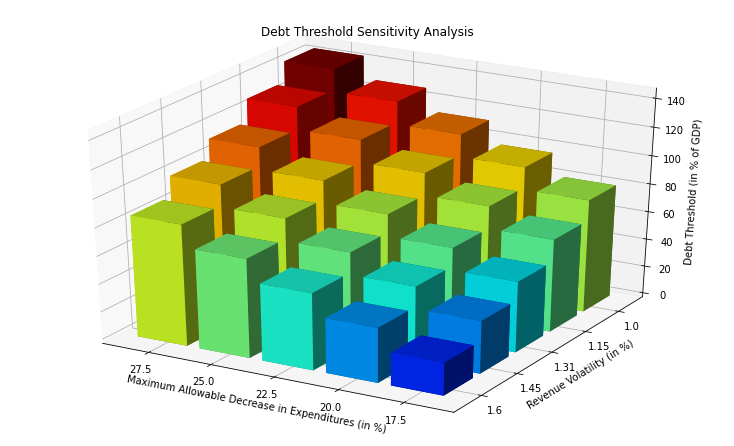

In [38]:
# user is free to assume based on sensitivity analysis to get max threshold, for our purposes we used 
# actual rev volatility as well as 22.5% max revenue reduction. maximum debt is one of the constraints in optimization model

# thickness of the bars
dx, dy = .8, .8

# prepare 3d axes
fig = plt.figure(figsize=(10,6))
ax = Axes3D(fig)

# set up positions for the bars 
xpos=np.arange(5)
ypos=np.arange(5)

# set the ticks in the middle of the bars
ax.set_xticks(xpos + dx/2)
ax.set_yticks(ypos + dy/2)

# create meshgrid 
# print xpos before and after this block if not clear
xpos, ypos = np.meshgrid(xpos, ypos)
xpos = xpos.flatten()
ypos = ypos.flatten()

# the bars starts from 0 attitude
zpos=np.zeros(mo_df.shape).flatten()

# the bars' heights
dz = mo_df.transpose().values.ravel()

colors = plt.cm.jet(dz.flatten()/float(dz.max()))

# plot 
ax.bar3d(xpos,ypos,zpos,dx,dy,dz,color = colors)

# put the column / index labels
ax.w_yaxis.set_ticklabels(mo_df.columns)
ax.w_xaxis.set_ticklabels(mo_df.index)

# name the axes
ax.set_xlabel('Maximum Allowable Decrease in Expenditures (in %)')
ax.set_ylabel('Revenue Volatility (in %)')
ax.set_zlabel('Debt Threshold (in % of GDP)')
ax.set_title('Debt Threshold Sensitivity Analysis')
plt.show()


# Step 4: Optimal Cash Balance

In [39]:
# in order to determine the optimal cash balance, the Miller-Orr model was used. 
# the return point is considered to be the optimal cash balance
# there is high flexibility on the use of other models to get an optimal cash balance as a constriant in the optimization model
# source: http://www.hkiaat.org/images/uploads/articles/PBEII%20Cash%20Management.pdf

df_cashflow = pd.read_csv("https://raw.githubusercontent.com/YungHapon/Hacklytics-2023---Team-BTr-PH/main/Files/Cash%20Flows.csv", index_col=0)

cf_ave = df_cashflow.values.mean()
cf_sd = df_cashflow.values.std()
cf_ll = cf_ave - cf_sd
cf_var = df_cashflow.values.var()
t_cost = 2.5 #transaction cost assumed that a transaction consists of 1 billion in issuances
ir_month = 0.055/12

spread = 3*(3*t_cost*cf_var/(4*ir_month))**(1/3)
return_point = cf_ll +spread/3


# Step 5: Optimization 

In [49]:
r = df_score["Shock Scenario Yields"]/100 #get data from step 1

def objective(t):

  
  t_sum = 0.000001 #sum of issuances
  for i in t:
    t_sum += i

  wair_new = 0
  for i in range(11):
    wair_new += t[i]*r[i]

  wair_new = wair_new/t_sum

  d = t_old + t_sum
  return t_sum*wair_new/d + t_old*wair_old/d


In [50]:
rev_proj = df_sim["Minimum Revenue"].iloc[1]/1000
exp_proj = df_sim["Maximum Expenditure"].iloc[1]/1000
optimal_cb = return_point/1000

def con1(t): # cash balance greater than optimal level
  t_sum = 0 #sum of issuances
  for i in t:
    t_sum += i
  
  dp_new = t[0] + t[1] + t[2] + t[3]
  ip_new = t[0]*r[0]/12 + t[1]*r[1]/4 + t[2]*r[2]/2 + t[3]*r[3]

  c = cb_old + t_sum +rev_proj - exp_proj - dp_old - ip_old - dp_new - ip_new - optimal_cb   #emerging cash bal next yr

  return c

In [52]:
def con2(t): #emerging debt < debt threshold
  t_sum = 0 #sum of issuances
  for i in t:
    t_sum += i

  return t_sum + t_old - gdp_new*debt_threshold

In [53]:
x0 = np.zeros(11) #initial values set to 0
b = (0.0,999999.0) #non negative constraint
bounds = (b,b,b,b,b,b,b,b,b,b,b) 

constraint1 = {"type": "ineq", "fun": con1}
constraint2 = {"type": "ineq", "fun": con2}
constraints = [constraint1, constraint2]

#the method for minimization is Sequential Least SQuares Programming optimizer
sol = minimize(objective, x0, method = "SLSQP", bounds = bounds, constraints = constraints) 

In [54]:
print(f"New Weighted Average Interest Rate: {round(sol.fun*100,4)}%")
print("Recommended debt issuances: ")

df_debt = pd.DataFrame(["1M","3M","6M","1Y","2Y","3Y","4Y","5Y","7Y","10Y","20Y"], columns=["Tenor"])
df_debt["Issuance in PhP blns"] = sol.x
df_debt.set_index("Tenor",inplace=True)

df_debt

New Weighted Average Interest Rate: 5.2398%
Recommended debt issuances: 


,Issuance in PhP blns
Tenor,
1M,211.078644
3M,209.286664
6M,205.162558
1Y,195.395608
2Y,420.982245
3Y,420.982245
4Y,420.982246
5Y,420.982246
7Y,420.982251
